# Introduction

## 1.Objective

YouTube nowadays is the largest video hosting website, and it has profound influences on US society in all aspects. Thus analyzing of youtube’s dataset become significant for companies to analyze the social trends and make a prediction for future strategic business plannings.   

The overall objective is for investors and advertisers. We will provide business recommendations for them, like which channels have more business value, what people are concerning now, and how to target customers precisely and explore potential customers,etc.

For the strategic decisions of investors, we will help them find the category that have relatively higher business potential. We drafted four judgment criterias, which are the number of videos in each category, the engagement rate (comment_count/view_count), the popularity rate (likes/view_count), and the average growth rate of showing up in trending, then there will be a weight value be assigned to those criterias.   

For advertisers, we help them predict what elements will become popular,and four drafted judgment criterias include  the changing rate of the frequency a channel on the trending board. The goal is that advertiser can choose to sign contract with these channel to make profit. In addition, they can choose these channels/YouTubers to see if they match the characteristics of their products and find potential customers. For example, we find that 'Billie Eilish' goes on trending every day this month, so we look up this channel, and found that is the most potential and popular new star in the U.S, who contains very strong and unique personal style. This information will bring up a very clear target customer for some business, like clothing buyers who can recommend similar style colthes to these audience. 




## 2. Data description

In order to get the data from youtube, we registered google developer account that we can have access to Google APIs. Then we used a script, which is downloaded from GitHub: https://github.com/DataSnaek/Trending-YouTube-Scraper, to collect data. This youtube scraper can scrape the most trending video from different countries, however, we will mainly focus on the US trending videos based on the data we collected through March and April 2019.   
We are collecting the data day by day and each day the data file we saved contains 200 records. There are about 4000+ observations with 20+ CSV files so far, but we will keep scraping data from Youtube trending data. Our sample dataset has 15 columns, which include:   

Video_id: the unique identity of a video   
Trending_date: the date that video is ranked   
Title: the title of video of the video   
Channel_title: the title of the channel which the video belongs to   
Category_id:  the category of video, which can be looked up using the included JSON files   
Publish_time: the time video was published   
Tags: the tags a video contains   
Views: the number of views each video have   
Likes:  the number of like each video have    
Dislikes: the number of dislikes each video have    
Comment_count: the number of comment each video have    
Thumbnail_link: the link connected to the cover page   
Comments_disabled: if  people can leave comments or not	   
Ratings_disabled: if people can rate the video or not   
Description: description of the video

# Data Prepartion

In [1]:
import numpy as np
import pandas as pd
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from wordcloud import WordCloud
import nltk
import datetime
# nltk.download()
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re

In [2]:
data=pd.read_csv("/Users/quanli/Downloads/Trending-YouTube-Scraper-master/output/19.06.03_US_videos.csv")
colnames=list(data)

Since the data is stored in separate files by date, we write a function to combine these data files into one dataset, and we import the big dataset for processing and analyzing.

In [3]:
def concatenate(indir="/Users/quanli/Downloads/Trending-YouTube-Scraper-master/output/",outfile="/Users/chenbaixue/Downloads/Trending-YouTube-Scraper-master/output/Data.csv"):
    os.chdir(indir)
    fileList=glob.glob("*.csv")
    dfList=[]
    for filename in fileList:
        df=pd.read_csv(filename,header=None)
        dfList.append(df[1:])
    concatDf=pd.concat(dfList,axis=0)
    concatDf.columns=colnames
    concatDf.to_csv(outfile,index=None)

In [4]:
concatenate(indir="/Users/quanli/Downloads/Trending-YouTube-Scraper-master/output/",outfile="/Users/chenbaixue/Downloads/Trending-YouTube-Scraper-master/output/Data.csv")

# Explore Data Analysis

## 1. Data Processing

First of all, we check the dataset and NAs, and there are several rows with only ‘video_id ’ exist but other columns show as NAs, so we simply delete these rows. Then there are still some NAs existing in ‘Description’ but that will not affect later analysis so we keep it in our dataset. In addition, in the dataset, we need to use an extra category_dictionary.json file to index the real category of each video. Then there are two columns have datetime value but not format as datetime, so we convert it to datetime. 

In [5]:
# Load data and view general information of dataset
data=pd.read_csv("/Users/quanli/Downloads/Trending-YouTube-Scraper-master/output/Data.csv")
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10021 entries, 0 to 10020
Data columns (total 16 columns):
video_id             10021 non-null object
title                10000 non-null object
publishedAt          10000 non-null object
channelId            10000 non-null object
channelTitle         10000 non-null object
categoryId           10000 non-null float64
trending_date        10000 non-null object
tags                 10000 non-null object
view_count           10000 non-null float64
likes                10000 non-null float64
dislikes             10000 non-null float64
comment_count        10000 non-null float64
thumbnail_link       10000 non-null object
comments_disabled    10000 non-null object
ratings_disabled     10000 non-null object
description          9965 non-null object
dtypes: float64(5), object(11)
memory usage: 1.2+ MB


,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,adzYW5DZoWs,Star Wars: The Rise of Skywalker – Teaser,2019-04-12T17:08:15.000Z,UCZGYJFUizSax-yElQaFDp5Q,Star Wars,24.0,19.14.04,Star Wars|Lucasfilm|Star Wars: Episode IX|JJ A...,17494243.0,429969.0,51877.0,71884.0,https://i.ytimg.com/vi/adzYW5DZoWs/default.jpg,False,False,Every generation has a legend. Watch the brand...
1,0GLbwkfhYZk,Star Wars Jedi: Fallen Order — Official Reveal...,2019-04-13T18:41:22.000Z,UCOsVSkmXD1tc6uiJ2hc0wYQ,EA Star Wars,20.0,19.14.04,Star Wars Jedi Fallen Order|Star Wars|Star War...,2125167.0,101509.0,3809.0,15366.0,https://i.ytimg.com/vi/0GLbwkfhYZk/default.jpg,False,False,Cal Kestis—one of the last surviving members o...
2,QuderoyWqII,Magic Star ⭐ Concealer & Setting Powder Reveal...,2019-04-12T19:00:59.000Z,UCkvK_5omS-42Ovgah8KRKtg,jeffreestar,26.0,19.14.04,jeffree star|jeffree star concealer|magic star...,5373596.0,289698.0,8386.0,36440.0,https://i.ytimg.com/vi/QuderoyWqII/default.jpg,False,False,The Magic Star™ Concealer & Setting Powder lau...
3,XsX3ATc3FbA,BTS (방탄소년단) '작은 것들을 위한 시 (Boy With Luv) feat. ...,2019-04-12T09:00:02.000Z,UC3IZKseVpdzPSBaWxBxundA,ibighit,10.0,19.14.04,BIGHIT|빅히트|방탄소년단|BTS|BANGTAN|방탄|작은 것들을 위한 시|Bo...,108445779.0,7597407.0,280945.0,2605772.0,https://i.ytimg.com/vi/XsX3ATc3FbA/default.jpg,False,False,BTS (방탄소년단) '작은 것들을 위한 시 (Boy With Luv) feat. ...
4,-9txATEWXTQ,THE TRUTH... My Crush Does My Makeup,2019-04-12T19:10:06.000Z,UCucot-Zp428OwkyRm2I7v2Q,James Charles,24.0,19.14.04,james|james charles|makeup artist|mua|covergir...,5721920.0,361039.0,9842.0,32205.0,https://i.ytimg.com/vi/-9txATEWXTQ/default.jpg,False,False,"HI SISTERS! In today's video, I wanted to fina..."


In [6]:
# Overview of nan values
data.isna().sum()

video_id              0
title                21
publishedAt          21
channelId            21
channelTitle         21
categoryId           21
trending_date        21
tags                 21
view_count           21
likes                21
dislikes             21
comment_count        21
thumbnail_link       21
comments_disabled    21
ratings_disabled     21
description          56
dtype: int64

In [7]:
# Drop all nan value in video identifers
data = data[pd.notna(data['title'])]

In [8]:
# Pair the category id with category title
categories={}
with open('/Users/quanli/Downloads/Trending-YouTube-Scraper-master/US_category_id.json', 'r') as f:
    category = json.load(f)
    for i in category['items']:
        categories[int(i['id'])]=i['snippet']['title']
        
data['category']=[categories[i] for i in data['categoryId']]

In [9]:
# Reformat the date and time columns
data['publishedAt'] = pd.to_datetime(data['publishedAt'], format='%Y-%m-%dT%H:%M:%S')
data['trending_date']=pd.to_datetime(data['trending_date'],format='%y.%d.%m')

In [10]:
# General view of the four numeric attributes
data[['view_count','likes','dislikes','comment_count']].describe()

,view_count,likes,dislikes,comment_count
count,1.000000e+04,1.000000e+04,10000.000000,1.000000e+04
mean,3.427541e+06,1.376545e+05,5037.541800,1.550961e+04
std,8.122748e+06,3.933908e+05,19400.530075,9.185268e+04
min,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,6.605620e+05,1.689550e+04,441.000000,2.041750e+03
50%,1.225098e+06,4.060200e+04,1012.000000,4.484000e+03
75%,2.905308e+06,1.149535e+05,2812.000000,1.085350e+04
max,1.954890e+08,9.079935e+06,446188.000000,3.121651e+06


There are some 0 between these numeric variables, but in general thses cannot be 0, so we will check what happen to them.

In [11]:
data.loc[(data['view_count'] ==0) | (data['likes'] ==0)|(data['dislikes'] ==0)|(data['comment_count'] ==0) ].head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,category
181,cHs1ffWg8-E,pregnancy + hope | shawn johnson + andrew east,2019-04-04 14:00:14+00:00,UCJ15Zl-v8-ghTgEOTpxHdGw,Shawn Johnson East,22.0,2019-04-14,shawn johnson|shawn johnson official|andrew ea...,1031583.0,40024.0,439.0,0.0,https://i.ytimg.com/vi/cHs1ffWg8-E/default.jpg,True,False,Subscribe to follow our journey ▶ http://bit.l...,People & Blogs
187,CcCRs0Ic3FI,The Boy Band Con: The Lou Pearlman Story,2019-04-03 13:00:19+00:00,UCqVDpXKLmKeBU_yyt_QkItQ,YouTube Originals,1.0,2019-04-14,*NSync|Backstreet Boys|Justin Timberlake|Lance...,0.0,0.0,0.0,2620.0,https://i.ytimg.com/vi/CcCRs0Ic3FI/default.jpg,False,True,The Boy Band Con: The Lou Pearlman Story is a ...,Film & Animation
272,JLE228ZuGGA,Apple Card Design,2019-03-27 22:14:00+00:00,UCE_M8A5yxnLfW0KghEeajjw,Apple,28.0,2019-03-31,Apple|iphone|apple card|credit card|applecard|...,705756.0,27621.0,3001.0,0.0,https://i.ytimg.com/vi/JLE228ZuGGA/default.jpg,True,False,"This is Apple Card. Titanium, laser-etched, no...",Science & Technology
334,DPvMPvUhc6E,TRYING ON MY MOMS WEDDING DRESS AND PROM DRESSES,2019-03-24 12:00:01+00:00,UCRPIJ_-fU0fycIi4a6PUXRg,The LeRoys,22.0,2019-03-31,THE LEROYS|the leyroys|kesley leroy|shanna ler...,657161.0,12895.0,550.0,0.0,https://i.ytimg.com/vi/DPvMPvUhc6E/default.jpg,True,False,To shop mine and Kesley's outfits : https://th...,People & Blogs
378,ZV7MMQNVnEg,S2E2: Splits,2019-03-21 00:57:20+00:00,UCkM3cLfmWBSFoEU-xVnQ-dw,Step Up: High Water,24.0,2019-03-31,Step Up|Step Up: High Water|Naya Rivera|Ne-Yo|...,0.0,8443.0,549.0,790.0,https://i.ytimg.com/vi/ZV7MMQNVnEg/default.jpg,False,False,The budding rivalry between Tal and Zo comes t...,Entertainment


For videos whose view_count is recorded as 0, we found that all the videos required a Youtube premium account to view, so we can not access their views.
For videos whose likes and dislikes are recorded as 0, we found that their channels disabled rating so that their likes can not be seen.
For videos whose comment_count is recorded as 0, we found that their channels also disabled comment.
As a result, we will exclude the 0 values in our following analysis on those variables.

## 2. Data Visualization

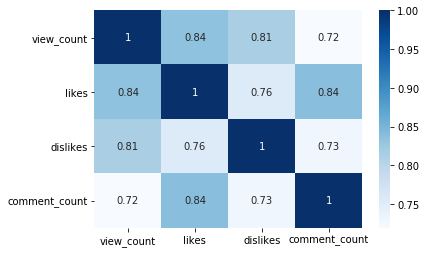

In [12]:
# Vlsualize the correlation between view_count, likes,dislikes, and comment_count
correlation=data[['view_count','likes','dislikes','comment_count']].corr()
sns.heatmap(correlation,cmap='Blues',annot=True)

By simply plot the heatmap we can see the correlations between view_count, likes, dislikes, and comment_count. So it seems that increase in like contribute the most in increase comment_count. View_count and comment_count don't have that strong correlation.

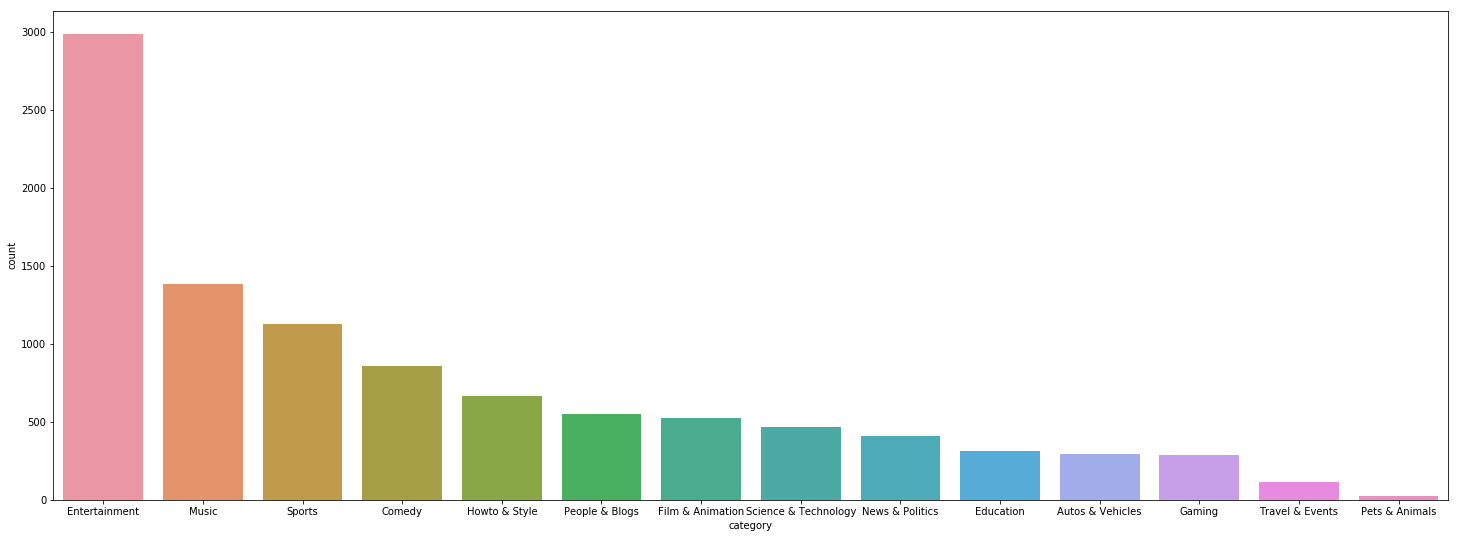

In [13]:
# Plot the number of video by category
plt.figure(figsize = (25,9))
sns.countplot(data['category'],order = data['category'].value_counts().index)

Entertainment has the most videos showing up in the trending video, which is more than twice the second. This only can present that the majority group of videos are belong to entertainment, and the competition under entertainment channels may be very fierce. Then we would like to see the distribution of 'view_count', 'likes', 'dislikes', 'comment_count' by different categories.

In [14]:
# Plot the distribution of 'view_count','likes','dislikes','comment_count'
view_count=np.log(data['view_count']+1 )
likes=np.log(data['likes']+1)
dislikes=np.log(data['dislikes']+1)
comment=np.log(data['comment_count']+1)
data_count=pd.concat([view_count,likes,dislikes,comment], axis=1)
data_count.index=data['category']
data_count=data_count[(data_count != 0)]


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

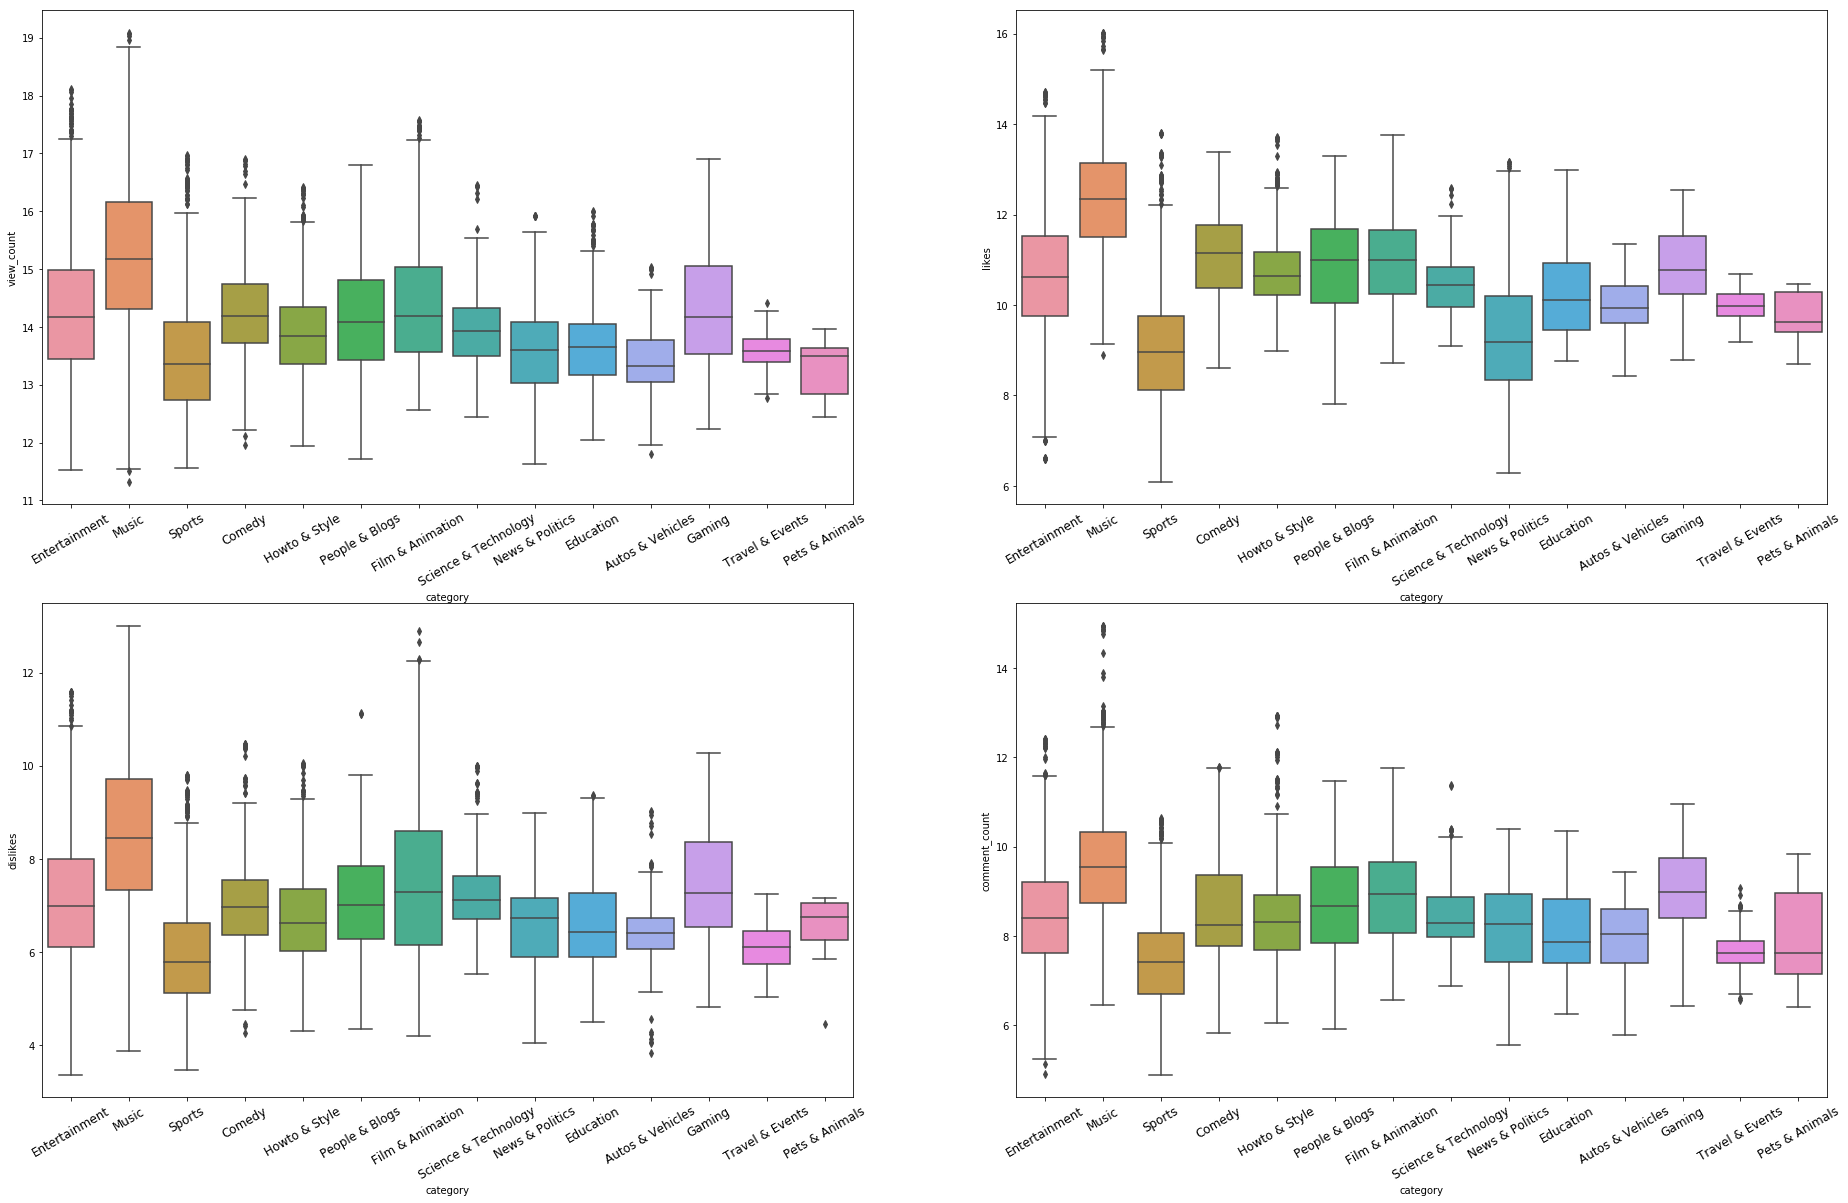

In [15]:
plt.figure(figsize=(32,20))
plt.subplot(2,2,1)
sns.boxplot(data_count.index,'view_count', data=data_count,order = data['category'].value_counts().index)
plt.xticks(rotation=30,fontsize=12)
plt.subplot(2,2,2)
sns.boxplot(data_count.index,'likes', data=data_count,order = data['category'].value_counts().index)
plt.xticks(rotation=30,fontsize=12)
plt.subplot(2,2,3)
sns.boxplot(data_count.index,'dislikes', data=data_count,order = data['category'].value_counts().index)
plt.xticks(rotation=30,fontsize=12)
plt.subplot(2,2,4)
sns.boxplot(data_count.index,'comment_count', data=data_count,order = data['category'].value_counts().index)
plt.xticks(rotation=30,fontsize=12)

In [16]:
general_view=pd.DataFrame(data[['view_count','likes','dislikes','comment_count']].groupby(data['category']).mean())


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 <a list of 14 Text xticklabel objects>)

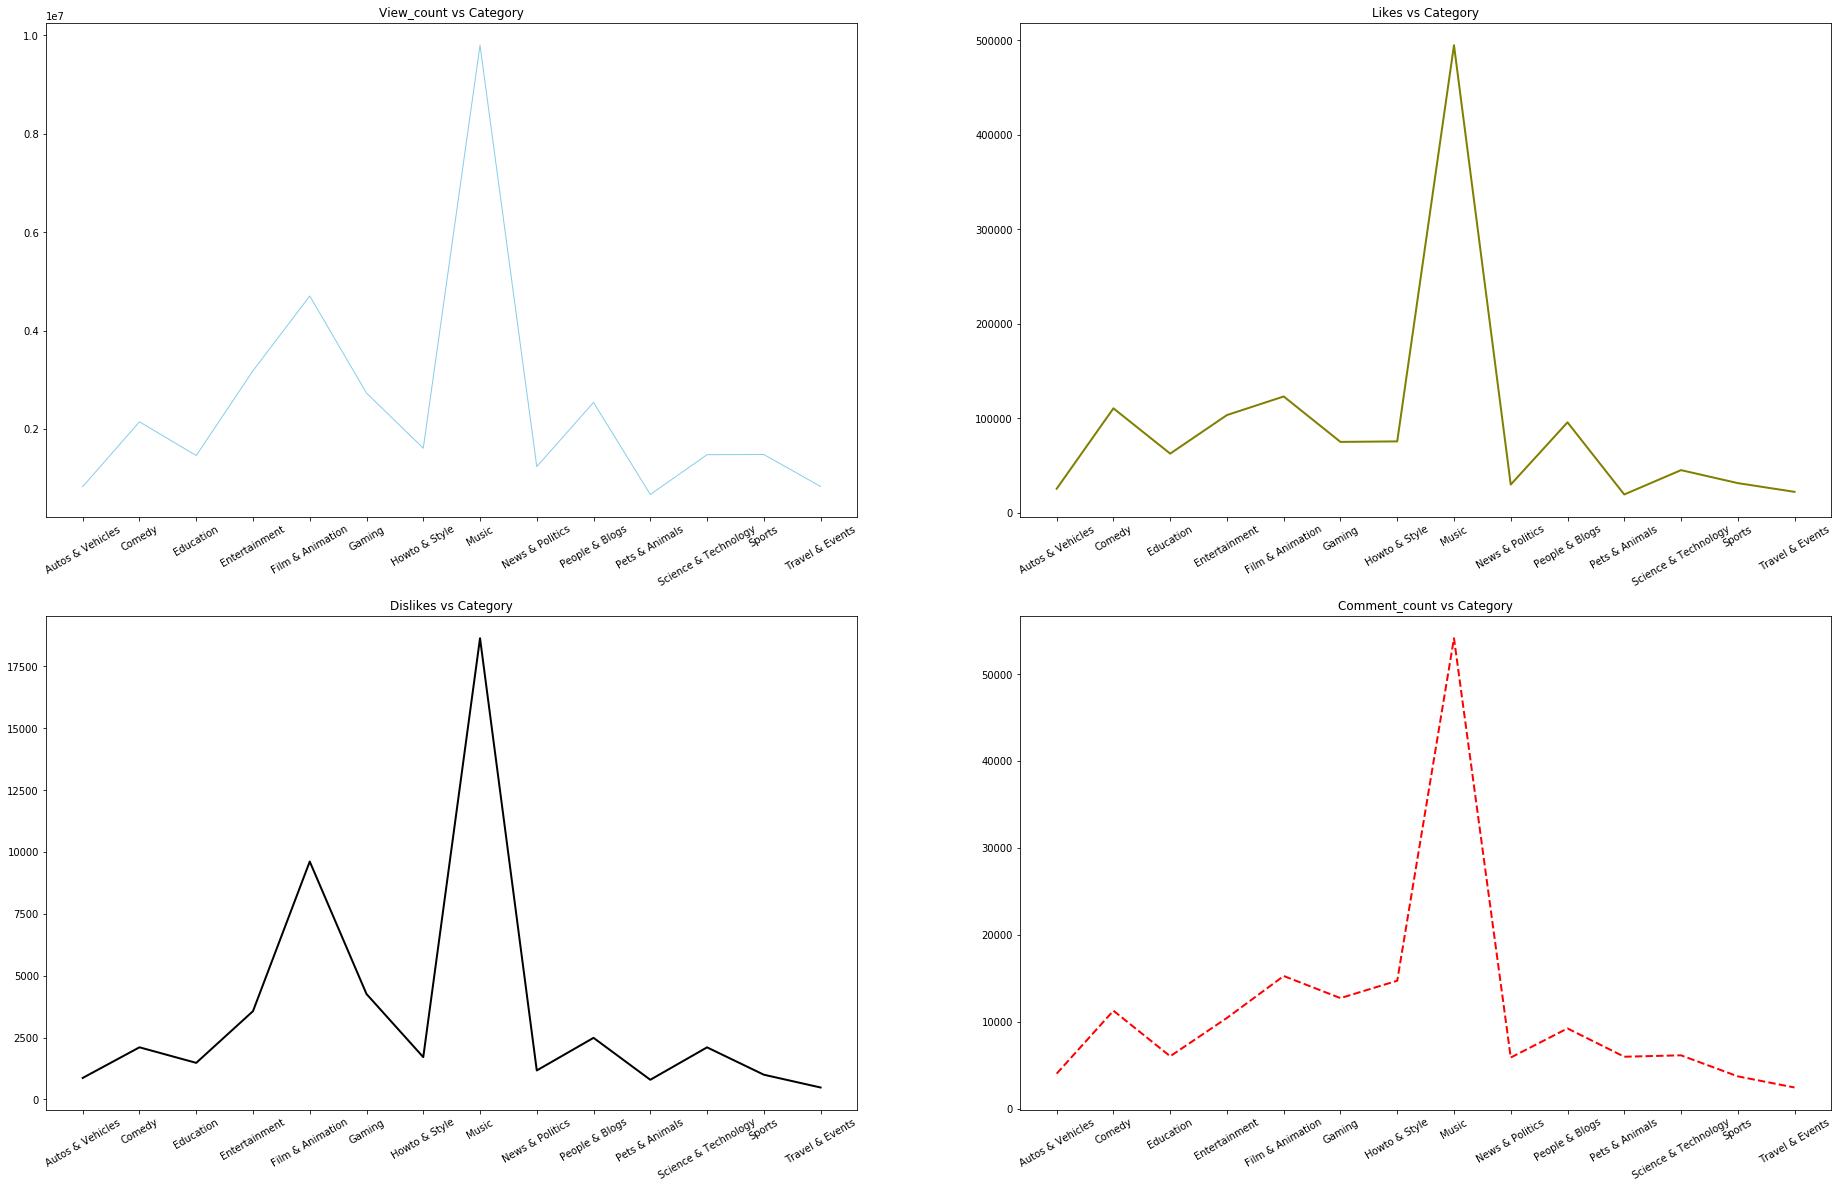

In [17]:
# The average of four numeric attributes 
plt.figure(figsize=(32,20))
plt.subplot(2,2,1)
plt.plot( general_view.index,'view_count' , data=general_view, color='skyblue', linewidth=1)
plt.title('View_count vs Category')
plt.xticks(rotation=30)
plt.subplot(2,2,2)
plt.plot( general_view.index, 'likes', data=general_view, color='olive', linewidth=2)
plt.title('Likes vs Category')
plt.xticks(rotation=30)
plt.subplot(2,2,3)
plt.plot( general_view.index, 'dislikes', data=general_view, color='black', linewidth=2)
plt.title('Dislikes vs Category')
plt.xticks(rotation=30)
plt.subplot(2,2,4)
plt.plot( general_view.index, 'comment_count', data=general_view, color='red', linewidth=2, linestyle='dashed')
plt.title('Comment_count vs Category')
plt.xticks(rotation=30)


By looking at the distribution of each attribute, we developed some insights:
some categories have obviously high variance, such as music, entertainments, film&Animation, etc. This present the variety of videos in these categories, which polarization is very serious. Oppositely, some categories have very condensed distribution, like travel, Pets & Animals, auto &vehicles. This may because these categories have smaller but more stable audience Sports got in the top three show up frequency on the last graph, but all four distributions are lower than others.
Pet also have the lowest view and number of video, but it shows more interactive between the audiences.
Comparing to the count view by category, which Entertainment has the highest value, Music becomes the top category on all four attributes based on the distributions, so this show that Entertainment may not be the most popular category, only because it has the largest video base so it can have so many videos go up on trending, but music gets the most attention from people. Since music is a very personal thing, so it shows a high ratio between likes and dislikes.


In [18]:
#the distribution of days that videos take to become popular
data['publish_date'] = data['publishedAt'].dt.date
data['publish_time'] = data['publishedAt'].dt.time
data['interval'] = (data['trending_date'].dt.date-data['publish_date']).astype('timedelta64[D]')
#Overview of distribution of interval
data.interval.describe()

count    10000.000000
mean         5.356400
std          3.256354
min          0.000000
25%          3.000000
50%          5.000000
75%          8.000000
max         24.000000
Name: interval, dtype: float64

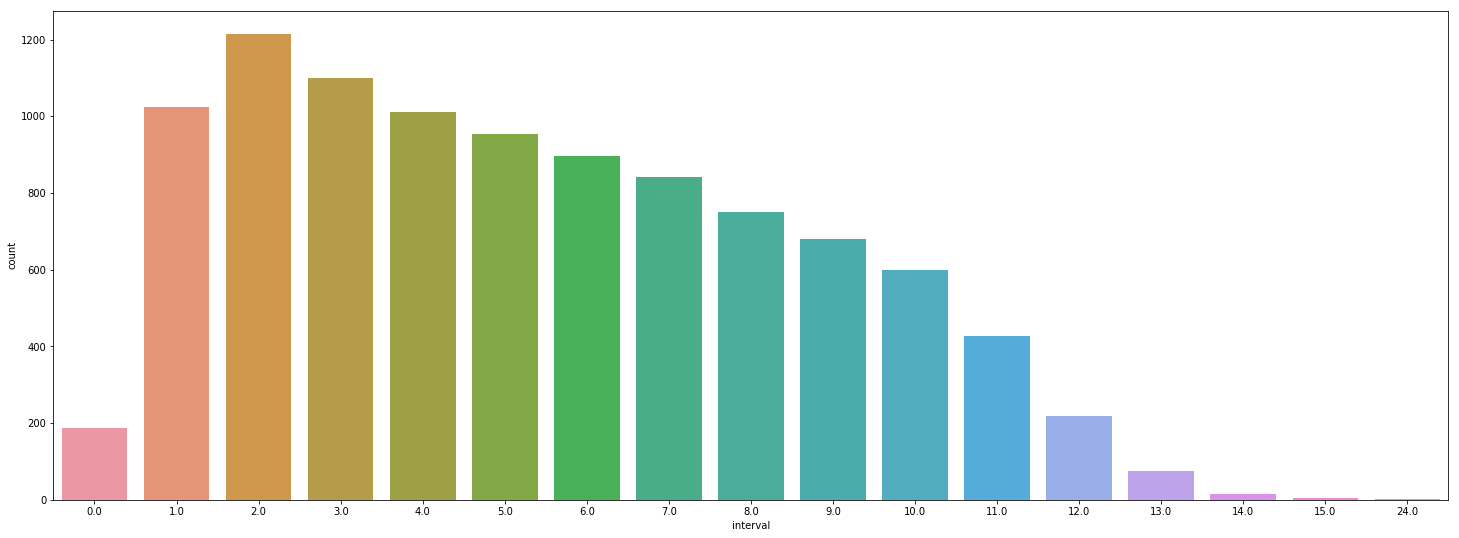

In [19]:
#Histgram of distribution of interval
plt.figure(figsize = (25,9))
sns.countplot(data['interval'])

The distribution of intervals between video's publishing time and trending time shows that frequncy of interval incease to more than 500 when interval is 2days, and then decrease. We also found that if a video is older than half a month, generally, it can not appear on trending board.

In [20]:
##Top videoes whoes view_count/likes grow fatest among categories

#calculate growth rate for each video
data['growth_rate_view'] = data['view_count']/(data['interval']+1)
data['growth_rate_like'] = data['likes']/(data['interval']+1)
data['growth_rate_dislike'] = data['dislikes']/(data['interval']+1)
data['growth_rate_comment'] = data['comment_count']/(data['interval']+1)

df = data.set_index(keys='title').groupby(by=['category'])['channelTitle','growth_rate_view'].apply(
    lambda g: g.nlargest(10,'growth_rate_view'))
df.head(40)

channelTitle  \
category         title                                                                                        
Autos & Vehicles Model Y Unveil                                                                       Tesla   
                 Model Y Unveil                                                                       Tesla   
                 Model Y Unveil                                                                       Tesla   
                 The McLaren Senna Is an Insane $1.8 Million Sup...                             Doug DeMuro   
                 Here's Why the 2019 BMW X7 Is the Best Big Luxu...                             Doug DeMuro   
                 Model Y Unveil                                                                       Tesla   
                 The Saleen S7 Is the Craziest Supercar Nobody K...                             Doug DeMuro   
                 How to Install a COMPLETELY New Front Suspensio...                                ChrisFix   
                 How to Install a Hidden Kill Switch in your Car...                                ChrisFix   
                 The Saleen S7 Is the Craziest Supercar Nobody K...                             Doug DeMuro   
Comedy           Maisie Williams Accidentally Drops a Major Spoi...  The Tonight Show Starring Jimmy Fallon   
                 Tom Brady Helps Jimmy Kimmel Vandalize Matt Dam...                       Jimmy Kimmel Live   
                 Maisie Williams Accidentally Drops a Major Spoi...  The Tonight Show Starring Jimmy Fallon   
                 The Spiders and the Bees                                                       TheOdd1sOut   
                 The Spiders and the Bees                                                       TheOdd1sOut   
                 The Spiders and the Bees                                                       TheOdd1sOut   
                 The Spiders and the Bees                                                       TheOdd1sOut   
                 The Spiders and the Bees                                                       TheOdd1sOut   
                 Avengers Cast on Premiere, Favorite Lines, Matc...                       Jimmy Kimmel Live   
                 The Spiders and the Bees                                                       TheOdd1sOut   
Education        What If We Detonated All Nuclear Bombs at Once?                 Kurzgesagt – In a Nutshell   
                 First Image of a Black Hole!                                                    Veritasium   
                 What If We Detonated All Nuclear Bombs at Once?                 Kurzgesagt – In a Nutshell   
                 What If We Detonated All Nuclear Bombs at Once?                 Kurzgesagt – In a Nutshell   
                 First Image of a Black Hole!                                                    Veritasium   
                 What If We Detonated All Nuclear Bombs at Once?                 Kurzgesagt – In a Nutshell   
                 The Origin of Consciousness – How Unaware Thing...              Kurzgesagt – In a Nutshell   
                 The Most Dangerous Stuff in the Universe - Stra...              Kurzgesagt – In a Nutshell   
                 What If We Detonated All Nuclear Bombs at Once?                 Kurzgesagt – In a Nutshell   
                 The Most Dangerous Stuff in the Universe - Stra...              Kurzgesagt – In a Nutshell   
Entertainment    Marvel Studios' Avengers: Endgame - Official Tr...                    Marvel Entertainment   
                 EXPERIMENT: LAVA vs FISH                                                            SkyBek   
                 Marvel Studios' Avengers: Endgame - Official Tr...                    Marvel Entertainment   
                 Marvel Studios' Avengers: Endgame - Official Tr...                    Marvel Entertainment   
                 EXPERIMENT: LAVA vs FISH                                                          

We found the top videos with highest growth rates of views were published by certain youtube channels, meaning that these channels can attract lots of people in a short time. So, advertisers and investors can find valuable channels to cooperate.

In [21]:
Channel=pd.DataFrame(data['channelTitle'].groupby(by=[data['channelTitle'],data['category']]).count())
Channel.columns=['count']
Top_channel=Channel.nlargest(100,['count'])
Top_channel

,,count
channelTitle,category,
Binging with Babish,Entertainment,50
FBE,Entertainment,50
Good Mythical MORE,Entertainment,50
Good Mythical Morning,Entertainment,50
James Charles,Entertainment,50
Linus Tech Tips,Science & Technology,50
Marques Brownlee,Science & Technology,50
REACT,Entertainment,50
Skip and Shannon: UNDISPUTED,Sports,50


We would like to know which channels are the most productive, and what categories they belong to. so we find the top 100 channels that have the most videos pop up on trending. It seems that these channels with 24videos get on trending every day, so we will explore more on these channels.

# 3. Sentiment Analysis


The goal of performing sentiment analysis here is to identify the keywords associated with a video to be able to categorize them. For example, a video with the title “BBC Channel” will belong to the News & Politics category and so on. Similarly, we also perform word cloud on description and tags of the video to get a visual representation of what Youtubers are specify on their video.           
We intend to obtain a quick overall sense for what elements a channel performed to audience. We could recommend a detailed trending YouTube Video image description to help investors and advertisers to identify those potential trending videos. 

In [22]:
category_list = data['category'].unique()
category_list

array(['Entertainment', 'Gaming', 'Howto & Style', 'Music', 'Comedy',
       'Sports', 'Autos & Vehicles', 'Film & Animation',
       'News & Politics', 'People & Blogs', 'Pets & Animals', 'Education',
       'Science & Technology', 'Travel & Events'], dtype=object)

In [23]:

#Collect all the related stopwords.
en_stopwords = list(stopwords.words('english'))
polarities = list()
MAX_N=10000

for i in category_list:
    tags_word = data[data['category']==i]['tags'].str.lower().str.cat(sep=' ')

# removes punctuation,numbers and returns list of words
    tags_word = re.sub('[^A-Za-z]+', ' ', tags_word)
    word_tokens = word_tokenize(tags_word)
    filtered_sentence = [w for w in word_tokens if not w in en_stopwords]
    without_single_chr = [word for word in filtered_sentence if len(word) > 2]

# Remove numbers
    cleaned_data_title = [word for word in without_single_chr if not word.isdigit()]      
    
# Calculate frequency distribution
    word_dist = nltk.FreqDist(cleaned_data_title)
    hnhk = pd.DataFrame(word_dist.most_common(MAX_N),
                    columns=['Word', 'Frequency'])

    compound = .0
    for word in hnhk['Word'].head(MAX_N):
        compound += SentimentIntensityAnalyzer().polarity_scores(word)['compound']

    polarities.append(compound)

Text(0.5,1,'\nPolarity of Different Categories videos\n')

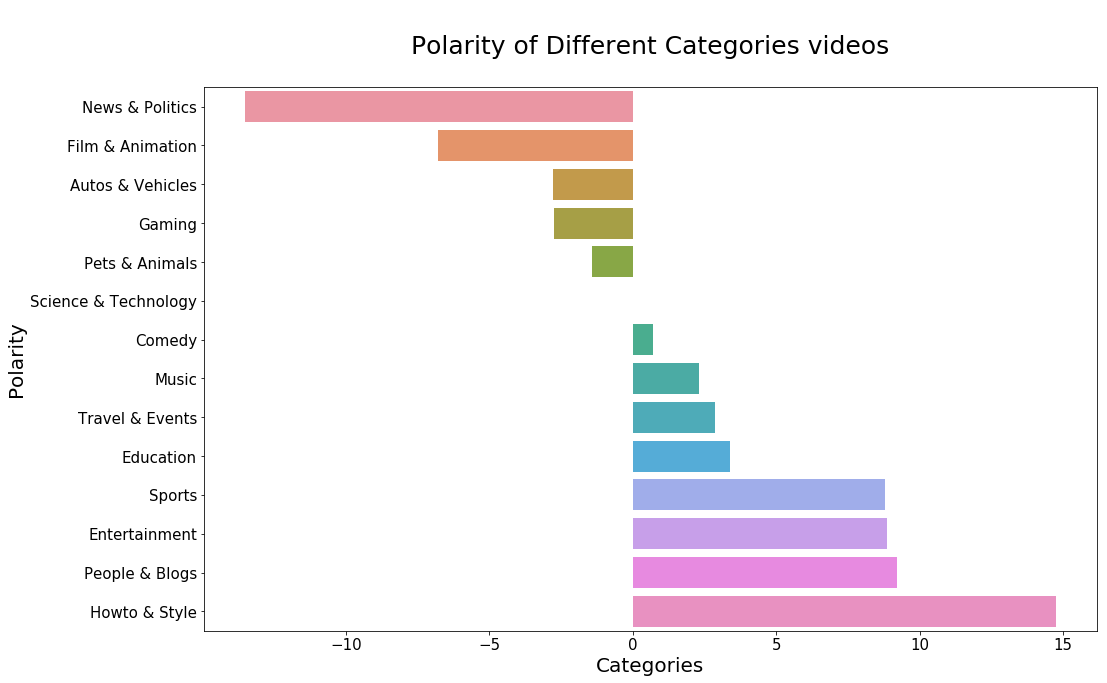

In [24]:

category_list = pd.DataFrame(category_list)
polarities = pd.DataFrame(polarities)
tags_sentiment = pd.concat([category_list,polarities],axis=1)
tags_sentiment.columns = ['category','polarity']
tags_sentiment=tags_sentiment.sort_values('polarity').reset_index()

plt.figure(figsize=(16,10))
ax = sns.barplot(x=tags_sentiment['polarity'],y=tags_sentiment['category'], data=tags_sentiment)

plt.xlabel("Categories",fontsize=20)
plt.ylabel("Polarity",fontsize=20)
plt.yticks(fontsize=15) 
plt.xticks(fontsize=15)
plt.title("\nPolarity of Different Categories videos\n", fontsize=25)



By using sentiment analyzer from NLTK, we can examine the polarities of tags from all category Youtube Trending Videos. The News& Politics category, at (-10), has not only the highest share of negative polarity sentiment but also the highest percentage of  comments_count. , which indicates the sentiment of audiences usually critical; Considering that political issues are often polarizing topics, this result seems to be reasonable.

While Entertainment, music, and sports videos have positive polarity. The categories of videos have a specific type of audiences. We recommend that the audiences watching Positive polarity videos if the audiences have a Harmonious atmosphere party because the relatively higher positive polarity videos are usually family-friendly and those videos will also have a higher positive comment.


In [25]:
def word_cloud(data):
    plt.figure(figsize = (20,15),facecolor = None)
    cloud = WordCloud(background_color = 'black', colormap="tab20b_r",max_words=2000, max_font_size=40, random_state=42)
    cloud.generate(' '.join(data))
    plt.imshow(cloud)
    plt.axis('off')
    plt.title("\nWord cloud for " + 'data' + "\n", fontsize=45)

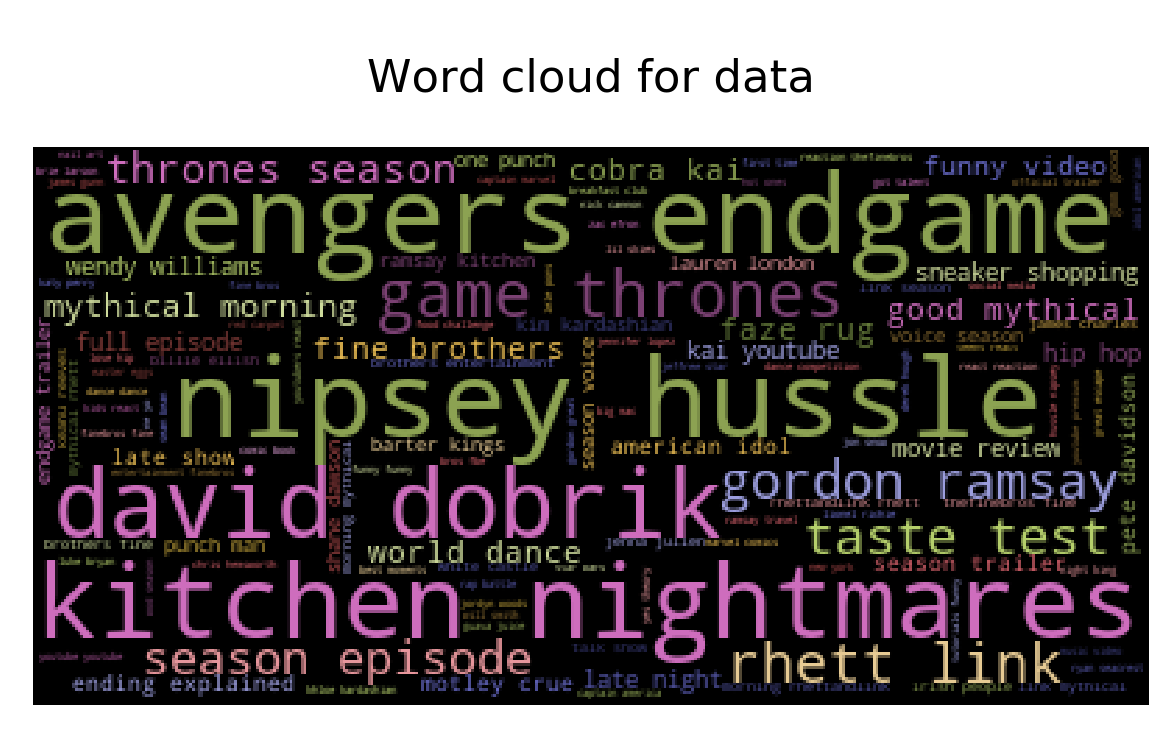

In [26]:
tags_word = data[data['category']=='Entertainment']['tags'].str.lower().str.cat(sep=' ')

word_tokens = word_tokenize(tags_word)
filtered_sentence = [w for w in word_tokens if not w in en_stopwords]
without_single_chr = [word for word in filtered_sentence if len(word) > 2]
cleaned_data_title = [word for word in without_single_chr if not word.isdigit()]

word_cloud(cleaned_data_title)

# Project Progress Updated

  
First, we cleaned the data and processed the data for data analysis, which includes removing NAs, reformatting data, creating new variables, and looking up the distribution of data to see if all data are reasonable. By exploring data we find these general statistic results, like the relations among site traffic KPIs, which category has the most channels and video, what category people are concerned the most, which channels have the top frequency of video appearance, what's the period time to become a trending video, which categories have negative sentiment, etc. For example, Pet&Animals, Travel may be very potential categories since they got a lot of attention but only a few channels show up, so we will look at the details from these categories. By applying sentiment analysis, we got several categories are negative. Next, we performed word cloud on categories to get a deep sentiment analysis of those videos and what are the most frequently mentioned keywords in those positive sentiment videos. So far we just have a general view of different aspects of data, and we cannot make any conclusion yet.     

The next stage we will analysis based on these statistic results we found and dig into details. We will calculate the average growth rates by dividing counted values to time intervals, and weight the popularity rate, engagement rate to get a final ranking results. We will keep looking down into channels by categories since different category represents a different group of audience, and we will analyse the behaviors/phenomenon behind these statistics, like the changing rate of the like/dislike ratio. We found that there are many trending videos managed to get a large number of views counts, but they have very few likes, so we could analyze the reason for this abnormal situation. In addition, for the overall report quality, we will revise our graphs for better visualization to make a comprehensive performance evaluation further. For the sentiment analysis part, we will revise the word cloud algorithm to have more valuable and informational tags appear, and we have planned for additional analysis for description sentiment. 